## Audiofile Processing

In [24]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
from scipy.signal import butter, filtfilt, hilbert, spectrogram
from scipy.ndimage import gaussian_filter1d

In [37]:
# functions for signal processing
def gain_compensation(data, gain):
    linear_gain = 10 ** (gain / 20)
    calibrated_data = data / linear_gain
    return calibrated_data

def time_avg_freq_spectrum(data, fs, nperseg=2048):
    f, t, Sxx = spectrogram(data, fs, nperseg=nperseg)
    # average spectrum over time
    cols = np.arange(len(t))
    spec_avg = Sxx[:, cols].mean(axis=1)
    spec_sm = gaussian_filter1d(spec_avg, 2) # smooth with gaussian filter; sigma=2
    return f, spec_sm

def bandpass_filter(data, fs, lowcut, highcut, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band') # get filter coefficients
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def filtering_and_amplification(data, fs, lowcut, highcut):
    # first filter and amplification
    filt1 = bandpass_filter(data, fs, lowcut, highcut)
    filt2 = filt1 * 20 
    # second filter and amplification
    filt3 = bandpass_filter(filt2, fs, lowcut, highcut)
    filt_def = filt3 * 10
    return filt_def

def envelope_extraction(data):
    analytic_signal = hilbert(data)
    envelope = np.abs(analytic_signal)
    return envelope

def rectangular_waveform(envelope, gains):
    threshold = 2 # volts
    # first column of results is the time index of detected impulses
    rect_hilbert = pd.DataFrame({'time': time})
    # loop over channels, apply gain, and detect impulses
    for ch, gain in gains.items():
        amplified = envelope * gain
        # create binary array: 1 if in threshold, else 0
        binary = ((amplified > threshold)).astype(int)
        # convert to 5 V pulse
        rectangular = binary * 5
        rect_hilbert[f'ch{ch}'] = rectangular
    return rect_hilbert

def count_impulses(rectangular, time, gains):
    dt = 1.0 # target bin size in seconds
    # build bins
    time_bins = np.arange(time[0], time[-1] + dt, dt) # include last bin edge
    time_index = pd.to_timedelta(time_bins[:-1], unit="s") # exclude last edge for index
    # prepare output array
    results = pd.DataFrame(index=time_index)
    # loop over channels
    for ch, gain in gains.items():
        rect_signal = rectangular[f"ch{ch}"].values
        # detect rising edges: 0→5 transitions
        rising_edges = np.diff((rect_signal > 0).astype(int)) == 1
        edge_times = time[1:][rising_edges]
        # bin counts into 1 s intervals
        counts, _ = np.histogram(edge_times, bins=time_bins)
        results[f"impulses_ch{ch}"] = counts
    return results

def quantify_impacts(results, envelope, rectangular, time, gains, file_name):
    # 1. add the original envelope as 'hilbert' column
    env_series = pd.Series(envelope, index=pd.to_timedelta(time, unit="s"))
    results["hilbert"] = env_series.resample("1s").mean()

    # 2. add rectangular waveforms and envelopes (resampled to 1 Hz)
    for ch in gains.keys(): 
        rect_series = pd.Series(rectangular[f"ch{ch}"].values, index=pd.to_timedelta(time, unit="s"))
        results[f"rect_ch{ch}"] = rect_series.resample('1s').max() # use max to keep 5V pulses
        # add per channel envelopes (amplified by gain)
        env_series = pd.Series(envelope * gains[ch], index=pd.to_timedelta(time, unit="s"))
        results[f"env_ch{ch}"] = env_series.resample("1s").mean()

    # 3. define analysis window (entire recording)
    t0 = time.min()  # start of entire period
    t1 = time.max()  # end of entire period
    window = results

    # 4. compute summary statistics over entire period
    impulse_sums = window.filter(like="impulses_ch").sum() # sum impulses per channel over entire period
    # amplitude stats (full envelope during entire period)
    max_amp = window["hilbert"].max()
    mean_amp = window["hilbert"].mean()
    median_amp = window["hilbert"].median()

    # 5. parse file name for date and time 
    base_name = os.path.basename(file_name).replace('.flac', '')  # remove extension
    date_time_part = base_name.split('_')[1]  # get "MMDDYY-HHMMSS"
    date_part, time_part = date_time_part.split('-')  # split into date and time
    # format date: MMDDYY -> MM/DD/YY
    formatted_date = f"{date_part[:2]}/{date_part[2:4]}/{date_part[4:]}"
    # format time: HHMMSS -> HH:MM:SS
    formatted_time = f"{time_part[:2]}:{time_part[2:4]}:{time_part[4:]}"
    # combine date and time
    datetime_string = f"{formatted_date} {formatted_time}"
    # collect results
    summary = {
        "time": datetime_string,
        "max_amp": max_amp,
        "mean_amp": mean_amp,
        "median_amp": median_amp
    }
    summary.update(impulse_sums.to_dict())  # add channel impulse counts

    # 6. calculate max, mean and median envelope only during impulses 
    for ch in gains.keys():
        impulse_mask = window[f"rect_ch{ch}"] > 0  # mask for times with impulses
        if impulse_mask.any():
            max_env = window.loc[impulse_mask, f"env_ch{ch}"].max()
            mean_env = window.loc[impulse_mask, f"env_ch{ch}"].mean()
            median_env = window.loc[impulse_mask, f"env_ch{ch}"].median()
        else:
            max_env = mean_env = median_env = 0  # no impulses detected
        summary[f"max_env_ch{ch}"] = max_env
        summary[f"mean_env_ch{ch}"] = mean_env
        summary[f"median_env_ch{ch}"] = median_env
    return summary

gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

Test

In [26]:
file_name = 'Calibration/EXP-09-20-23-FLOW2/audio/Nicole_091823-000100.flac'
raw_data, fs = sf.read(file_name)
# pipe is left channel 
if raw_data.ndim > 1:
    raw_data = raw_data[:,0] # keep the left channel, which in this case is the impact pipe

# gain compensation
data = gain_compensation(raw_data, 23) # gain compensation for preamp (23 dB)
# time vector
time = np.arange(len(data)) / fs

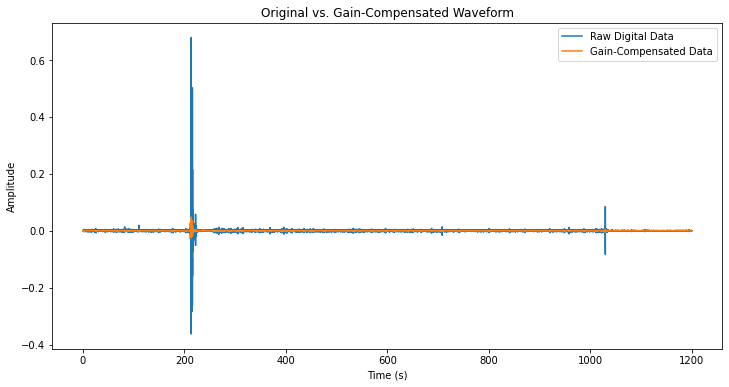

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(time, raw_data, label="Raw Digital Data")
plt.plot(time, data, label="Gain-Compensated Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs. Gain-Compensated Waveform")
plt.legend(loc='upper right')
plt.show()

In [28]:
# get averaged frequency spectrum
frequencies, spectrum = time_avg_freq_spectrum(data, fs)
# filter and amplify signal
filtered_data = filtering_and_amplification(data, fs, 700, 1500)

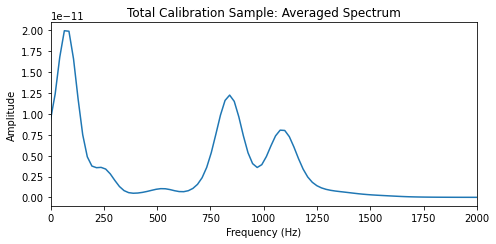

In [29]:
# plot the averaged and smoothed spectrum
plt.figure(figsize=(7,3.5))
plt.plot(frequencies, spectrum, label="average spectrum")
plt.xlim(0, 2000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Total Calibration Sample: Averaged Spectrum")
plt.tight_layout()
plt.show()

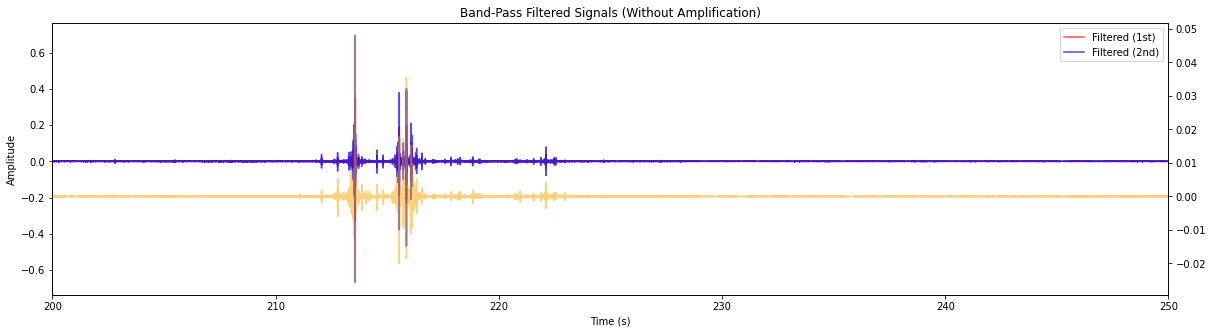

In [30]:
# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(time, filtered_data/20, label="Filtered (1st)", color='red', alpha=0.7)
plt.plot(time, filtered_data/10, label="Filtered (2nd)", color='blue', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signals (Without Amplification)")
plt.legend(loc='upper right')
twin = plt.twinx()
twin.plot(time, data, label="Original", color='orange', alpha=0.5)

plt.xlim(200, 250)  # zoom in to see details
plt.show()

In [31]:
# extract envelope
envelope = envelope_extraction(filtered_data)

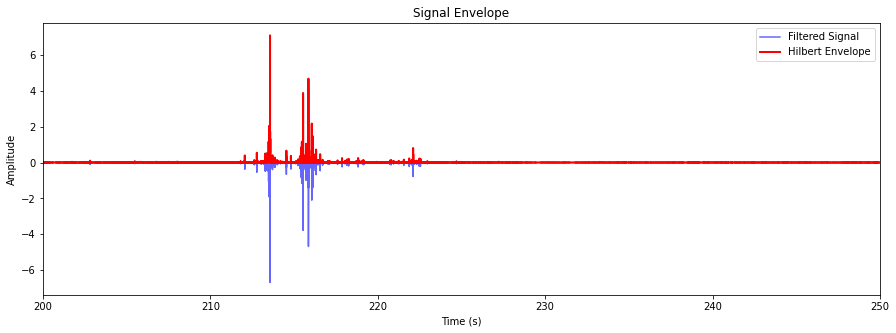

In [32]:
# visualize the envelope
plt.figure(figsize=(15, 5))
plt.plot(time, filtered_data, 'b-', label='Filtered Signal', alpha=0.6)
plt.plot(time, envelope, 'r-', linewidth=2, label='Hilbert Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal Envelope")
plt.legend(loc='upper right')
plt.xlim(200, 250)
plt.show()

In [33]:
rectangular = rectangular_waveform(envelope, gains)

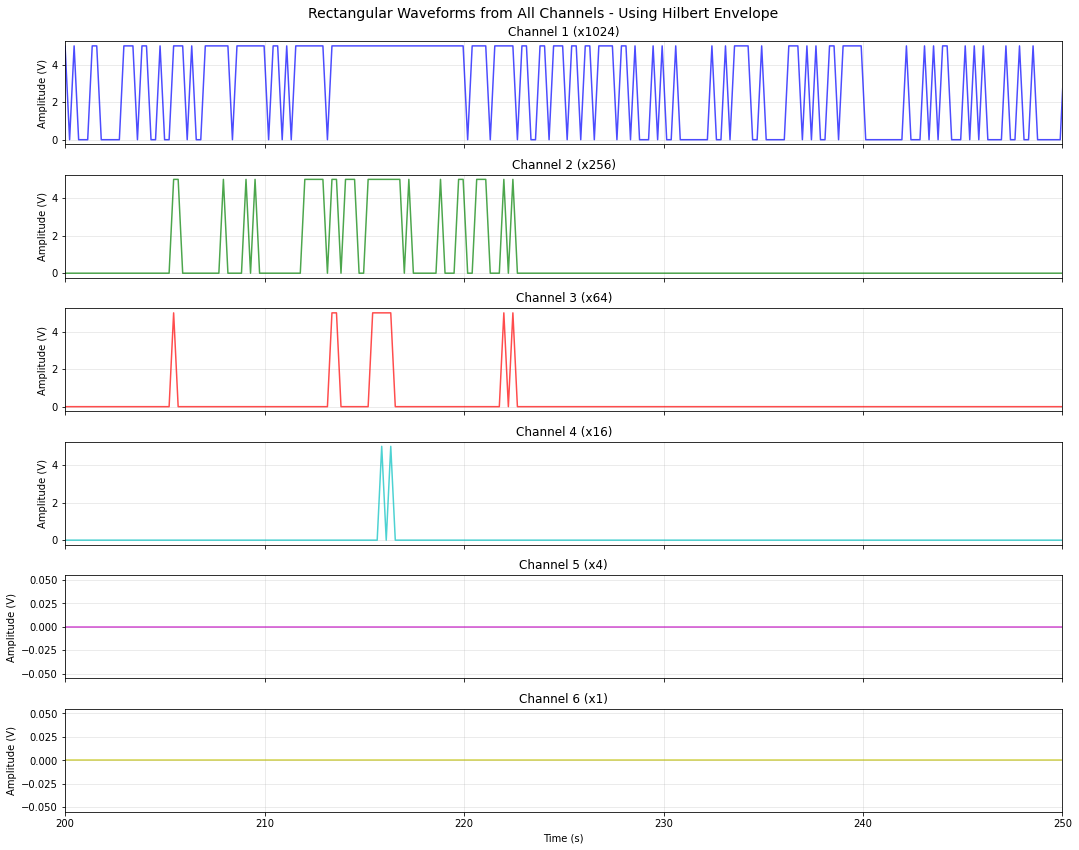

In [34]:
# visualize rect waveforms from hilbert envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains_db = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000  

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains_db)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rectangular['time'][::downsample_factor]
    downsampled_signal = rectangular[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
for ax in axes:
    ax.set_xlim(200, 250)

plt.suptitle("Rectangular Waveforms from All Channels - Using Hilbert Envelope", fontsize=14)
plt.tight_layout()
#plt.savefig("calibration_plots/floods/f2/f2_rect_from_hilbert.png", dpi=300, bbox_inches='tight')
plt.show()

In [36]:
results = count_impulses(rectangular, time, gains)
final = quantify_impacts(results, envelope, rectangular, time, gains, file_name)

KeyError: 'hilbert'

### Storm 1: 07/23/21